ANALYSES SISMIQUE DEPUIS 1965

IMPORT DES LIBRAIRIES


In [2]:
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 install seaborn
#!pip3 install sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from time import perf_counter 
import warnings
#!pip3 install folium
import datetime
#import folium
#from folium import Choropleth
#from folium.plugins import HeatMap
warnings.simplefilter(action='ignore')



AFFICHAGE DU HEAD DU DATASET

In [3]:
hearthquake = pd.read_csv("./hearthquake.csv")
#Retrait colonnes vides
empty_columns = [col for col in hearthquake.columns
                     if hearthquake[col].isnull().any()]
hearthquake = hearthquake.drop(empty_columns, axis=1)
hearthquake.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


ICI ON VA CHARGER LES DATAS DES PLAQUES TECTONIQUES

In [4]:
tectonic_plates = pd.read_csv("./all.csv" )
tectonic_plates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


lE DATASET DES PLAQUES TECTONIQUES VA NOUS PERMETTRE DE GEOLOCALISER L'EMPLACEMENT DES SEISMES

En parcourant le dataset , dans la colonne date je me suis aperçu que 3 date n'était pas formaté comme les autres ainsi que la colone time.
Je vais donc les reformater. 

In [5]:
lengths_date = hearthquake["Date"].str.len()
lengths_date.value_counts()
dates_to_reformate = np.where([lengths_date == 24])[1]
#Je n'ai pas réussi à convertir automatiquement , j'ai donc fait le remplacement manuellement
hearthquake.loc[3378, "Date"] = "02/23/1975"
hearthquake.loc[3378, "Time"] = "02:58:41"
hearthquake.loc[7512, "Date"] = "04/28/1985"
hearthquake.loc[7512, "Time"] = "02:53:41"
hearthquake.loc[20650, "Date"] = "03/13/2011"
hearthquake.loc[20650, "Time"] = "02:23:34"
hearthquake['Date']= pd.to_datetime(hearthquake["Date"])
hearthquake.info()
#On peut voir grace à info que la colonne date est bien un datetime maintenant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              23412 non-null  datetime64[ns]
 1   Time              23412 non-null  object        
 2   Latitude          23412 non-null  float64       
 3   Longitude         23412 non-null  float64       
 4   Type              23412 non-null  object        
 5   Depth             23412 non-null  float64       
 6   Magnitude         23412 non-null  float64       
 7   ID                23412 non-null  object        
 8   Source            23412 non-null  object        
 9   Location Source   23412 non-null  object        
 10  Magnitude Source  23412 non-null  object        
 11  Status            23412 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 2.1+ MB


Maintenant que nos données sont formatées correctement , alors on va voir lévolution des séismes avec le temps 

Text(0.5, 0, 'Date')

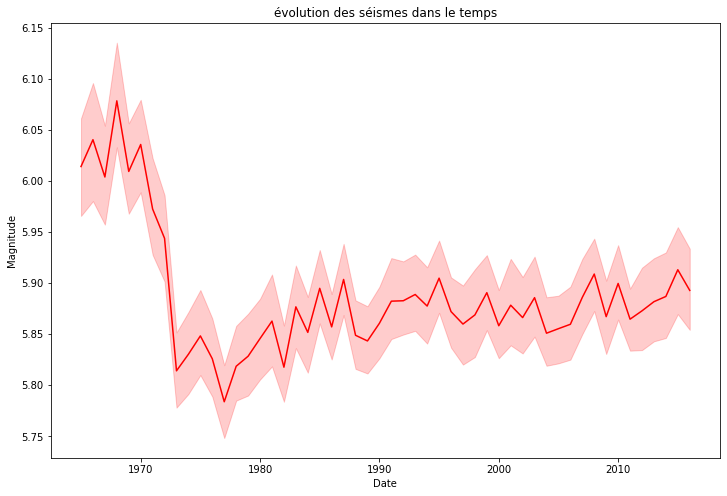

In [6]:
plt.figure(figsize=(12,8))
hearthquake_by_year = sns.lineplot(x=hearthquake['Date'].dt.year,y="Magnitude",data=hearthquake, color="#FF0000")
hearthquake_by_year.set_title("évolution des séismes dans le temps", color="#000000")
hearthquake_by_year.set_ylabel("Magnitude", color="#000000")
hearthquake_by_year.set_xlabel("Date", color="#000000")

Lors de mon parcours du data set , j'ai pu remarquer plusieurs types de séismes enregistrés, nous allons essayer de les visualiser

<AxesSubplot:xlabel='Type', ylabel='count'>

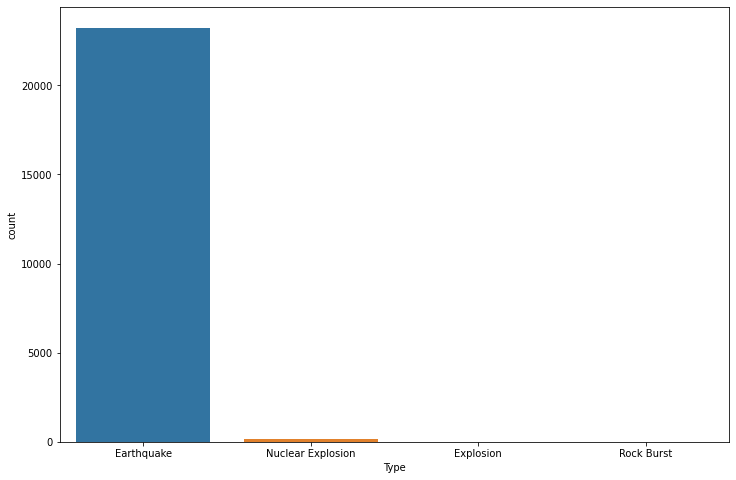

In [7]:
hearthquake_categorycal = hearthquake
#hearthquake_categorycal['Type'] = hearthquake['Type'].astype("category")
#hearthquake_categorycal['Type'] = hearthquake_categorycal['Type'].astype("category")
plt.figure(figsize=(12,8))

#categorical_columns = hearthquake.select_dtypes(['category']).columns
#hearthquake_categorycal['Type'] = hearthquake_categorycal['Type'].replace(to_replace=
                                        #['Earthquake', 'Nuclear Explosion', 'Explosion', 'Rock Burst'],
                                        #value=[1, 2, 3,4], inplace=True
                                       #)
hearthquake_categorycal.head()
#categorical_columns
#Index([u'col2', u'col3'], dtype='object')

sns.countplot(x="Type", data=hearthquake_categorycal)

([<matplotlib.patches.Wedge at 0x7fec3e0c9d90>,
 [Text(-0.02656642457863987, -1.0996791464264055, 'Earthquake'),
  Text(0.027304159591849703, 1.0996610763635235, 'Nuclear explosion'),
  Text(0.0013283062636256868, 1.0999991980008303, 'Explosion'),
  Text(0.0005902765133448506, 1.0999998416243695, 'Rock Burst')],
 [Text(-0.014490777042894473, -0.5998249889598575, '99%'),
  Text(0.014893177959190745, 0.5998151325619218, '1%'),
  Text(0.0007245306892503746, 0.5999995625459075, '0%'),
  Text(0.0003219690072790094, 0.5999999136132924, '0%')])

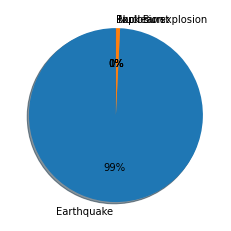

In [8]:
datas = []
nbquake = hearthquake[hearthquake["Type"] == 'Earthquake']
nbquakenuclear = hearthquake[hearthquake["Type"] == 'Nuclear Explosion']
nbquakerock = hearthquake[hearthquake["Type"] == 'Rock Burst']
nbquakeexplosion = hearthquake[hearthquake["Type"] == 'Explosion']

#nbquake['ID'].count()
#nbquakenuclear['ID'].count()
#nbquakerock['ID'].count()
#nbquakeexplosion['ID'].count()
datas = [nbquake['ID'].count(),nbquakenuclear['ID'].count(),nbquakerock['ID'].count(),nbquakeexplosion['ID'].count()]
label = ['Earthquake', 'Nuclear explosion', 'Explosion', 'Rock Burst']
plt.pie(datas, labels=label, autopct='%0.f%%', shadow=True, startangle=90)

Grace à ce chart on voit quon peut catégoriser les seismes en deux catégorie, les tremblements de terre naturels et ceux provoquer par une explosion, je vais donc regouper les trois catégories d'explosions ensemble

([<matplotlib.patches.Wedge at 0x7fec3e04c850>,
 [Text(-0.02656642457863987, -1.0996791464264055, 'Earthquake'),
  Text(0.026566350576576865, 1.0996791482141701, 'Explosion')],
 [Text(-0.014490777042894473, -0.5998249889598575, '99%'),
  Text(0.014490736678132833, 0.5998249899350018, '1%')])

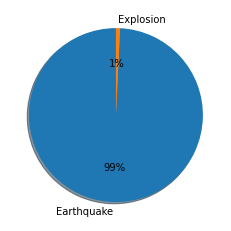

In [9]:
datas = [nbquake['ID'].count(),nbquakenuclear['ID'].count() + nbquakerock['ID'].count() + nbquakeexplosion['ID'].count()]
label = ['Earthquake', 'Explosion']
plt.pie(datas, labels=label, autopct='%0.f%%', shadow=True, startangle=90)

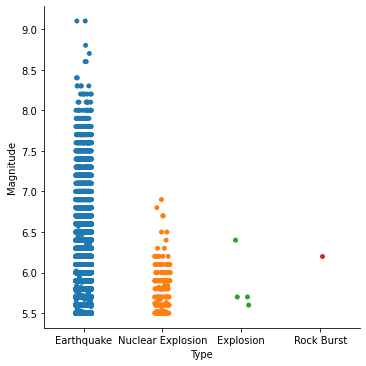

In [10]:
sns.catplot(x="Type", y='Magnitude',
                data=hearthquake_categorycal)

Ce graphique nous permet de voir qua la grande majorité des séismes sont d'ordre naturel et sont également les plus violents, lors du prochain graphique, nous allons essayer de déterminer la profondeur moyenne des séisme et leur magnitude moyenne 

Text(0.5, 0, 'Magnitude')

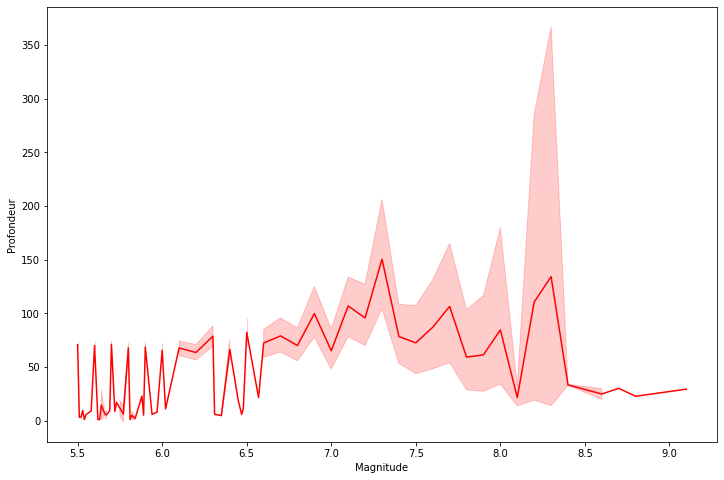

In [11]:
plt.figure(figsize=(12,8))
hearthquake_by_mag = sns.lineplot(x=hearthquake['Magnitude'],y="Depth",data=hearthquake, color="#FF0000")
#hearthquake_by_mag.set_title("évolution des séismes dans le temps", color="#000000")
hearthquake_by_mag.set_ylabel("Profondeur", color="#000000")
hearthquake_by_mag.set_xlabel("Magnitude", color="#000000")

In [12]:
hearthquake.mean()

Latitude      1.679033
Longitude    39.639961
Depth        70.767911
Magnitude     5.882531
dtype: float64

In [61]:
#map_tectonic_earthquake = folium.Map(tiles="cartodbpositron", zoom_start=5)
#linear_gradient = {.33: "#7a5195", .66: "#ef5675", 1: "#ffa600"} 
#plates = list(tectonic_plates["plate"].unique())
#for plate in plates:
#    plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#    lats = plate_vals["lat"].values
#    lons = plate_vals["lon"].values
#    points = list(zip(lats, lons))
#    indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#    for i in range(len(indexes) - 1):
#        folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]], popup=plate, color="#58508d", fill=False, ).add_to(map_tectonic_earthquake)
#        HeatMap(data=hearthquake[['Latitude','Longitude']], hue='Magnitude', min_opacity = 0.3, radius=1, gradient = linear_gradient ).add_to(map_tectonic_earthquake)
#map_tectonic_earthquake

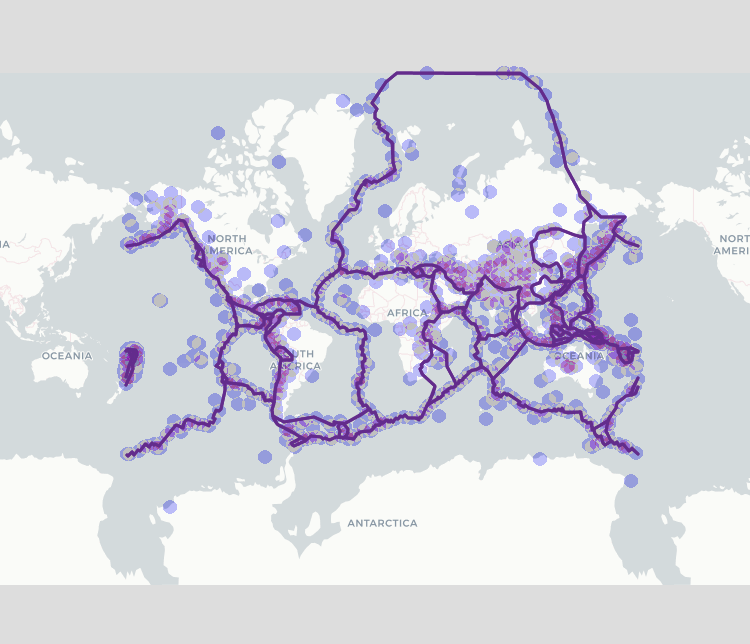

À l'aide de cette map, on peut voir que la grande majorité des séismes sont situé sur les délimitations des plaques tectoniques. la map sera en annexe du projet car elle trop lourde dans le notebook, on peut voir le code de la map commenter sur la case du dessus.

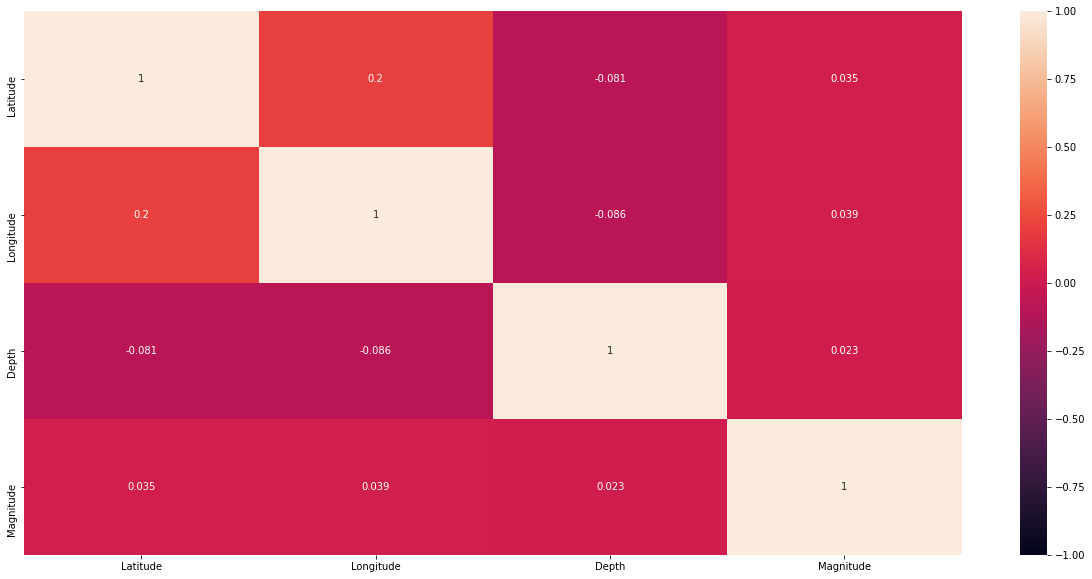

In [13]:
numeric_columns = [column for column in hearthquake.columns if hearthquake.dtypes[column] != 'object']
corr = hearthquake[numeric_columns].corr()
plt.figure(figsize=(21, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0)
plt.show()


Le premier algorythme de train va etre dédier à tenter de prédire la magnitude des seismes et peut etre la longitude et latitude

In [14]:
#hearthquake.info()
X = hearthquake[['Latitude','Longitude', 'Depth']]

X.shape

Y = hearthquake['Magnitude']
Y.shape
from sklearn.model_selection import train_test_split
#X, Y = train_test_split(new_frame, test_size=300, train_size=699, random_state=42, shuffle=True, stratify=None)
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.4, random_state=42)

In [15]:
from sklearn import linear_model

regr = linear_model.LinearRegression().fit(X_train, y_train)
print('Coefficients beta_j : \n', regr.coef_)
print('Coefficients INTERCEPT beta_0 : \n', regr.intercept_)


Coefficients beta_j : 
 [0.00047133 0.00014306 0.00010256]
Coefficients INTERCEPT beta_0 : 
 5.86803692879355


In [16]:

#afficher les coefficients 
regr.coef_

array([0.00047133, 0.00014306, 0.00010256])

[Text(0, 0, 'Latitude'), Text(1, 0, 'Longitude'), Text(2, 0, 'Depth')]

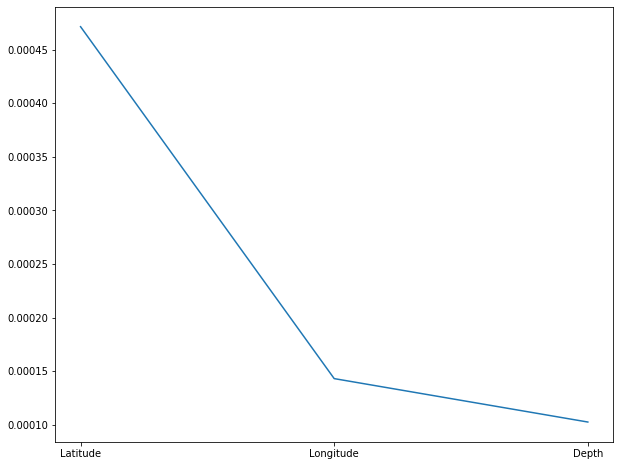

In [17]:

#ploter les coefficients avec les bon noms
#que remarquez vous ? 
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.xticks([0,1, 2,])
g = sns.lineplot(data= regr.coef_)
names = ['Latitude','Longitude', 'Depth']
g.set_xticklabels(names)

In [18]:

# Fit Model
linear_model.LinearRegression().fit(X_train, y_train)
# Predict
y_pred = regr.predict(X_test)
y_pred



array([5.90215452, 5.88549827, 5.89068392, ..., 5.86532361, 5.83859876,
       5.87029544])

Le second algorythme de train va etre dédier à tenter de prédire le type de séisme (naturel , ou explosion).

In [19]:
regr.score(X,Y)

0.003001562761637544

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,Y)
clf = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [21]:

from sklearn import linear_model
#X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = linear_model.Lasso(alpha=1)
clf.fit(X,Y)
print(clf.coef_)
print(clf.intercept_)

[0.00000000e+00 6.82704282e-05 2.04334446e-05]
5.878378484174358


[Text(0, 0, 'Latitude'), Text(1, 0, 'Longitude'), Text(2, 0, 'Depth')]

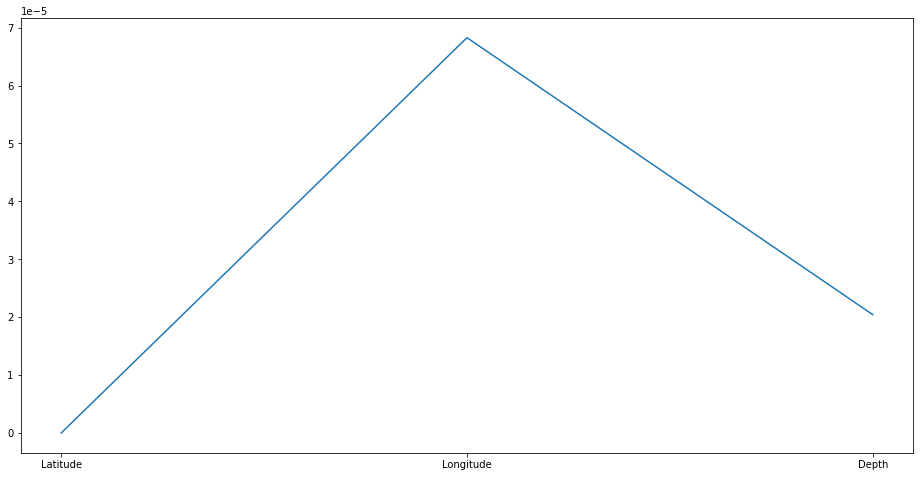

In [22]:
#ploter les coefficients avec les bon noms
#que remarquez vous ? 
from matplotlib import pyplot as plt
plt.figure(figsize=(16,8))
plt.xticks([0,1, 2])
g = sns.lineplot(data= clf.coef_)

g.set_xticklabels(names)

In [23]:
clf.score(X,Y)

0.0014159446758872374

Avec lasso meme échec , l'accuracy est encore pire , je vais essayer d'au moins prédire si le séisme est de type earthquake ou explosion ... lasso est je pense underfitting mais surement car l'algo n'est pas assez robuste pour faire ça

In [25]:
test = hearthquake

test = test.replace({"Type":{"Earthquake":1,"Explosion":0, "Nuclear Explosion": 0, "Rock Burst":0}})
print(test)

            Date      Time  Latitude  Longitude  Type   Depth  Magnitude  \
0     1965-01-02  13:44:18   19.2460   145.6160     1  131.60        6.0   
1     1965-01-04  11:29:49    1.8630   127.3520     1   80.00        5.8   
2     1965-01-05  18:05:58  -20.5790  -173.9720     1   20.00        6.2   
3     1965-01-08  18:49:43  -59.0760   -23.5570     1   15.00        5.8   
4     1965-01-09  13:32:50   11.9380   126.4270     1   15.00        5.8   
...          ...       ...       ...        ...   ...     ...        ...   
23407 2016-12-28  08:22:12   38.3917  -118.8941     1   12.30        5.6   
23408 2016-12-28  09:13:47   38.3777  -118.8957     1    8.80        5.5   
23409 2016-12-28  12:38:51   36.9179   140.4262     1   10.00        5.9   
23410 2016-12-29  22:30:19   -9.0283   118.6639     1   79.00        6.3   
23411 2016-12-30  20:08:28   37.3973   141.4103     1   11.94        5.5   

                 ID  Source Location Source Magnitude Source     Status  
0      ISCGEM

ici j'ai modifié les type de seismes en class afin de pouvoir utiliser un algorythme de forestClassifier. Ceci me permettra de tenter de prédire le type de séisme en fonction de la longitude / latitude / profondeur.

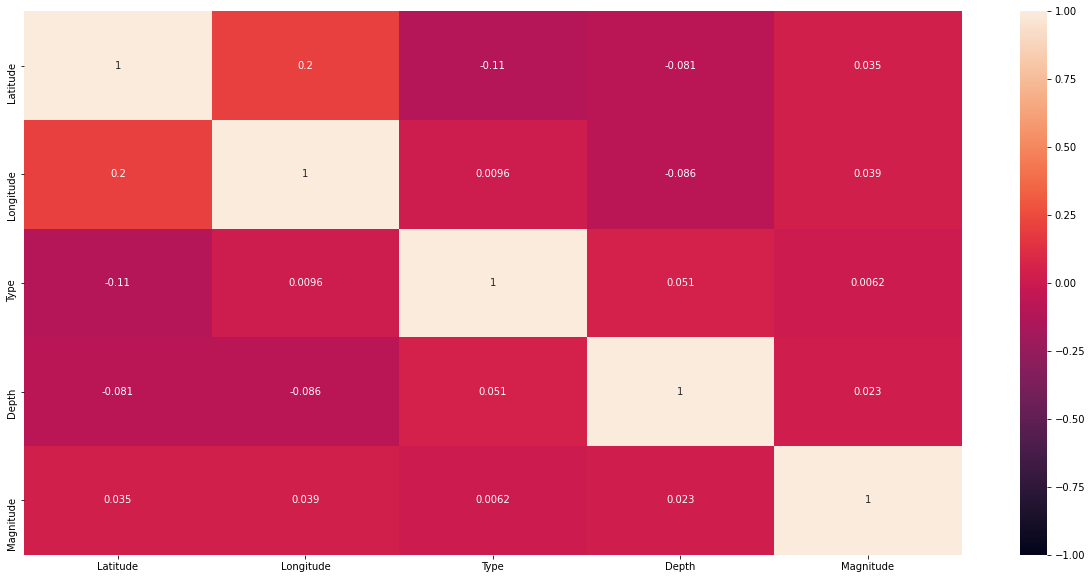

In [26]:
numeric_columns = [column for column in test.columns if test.dtypes[column] != 'object']
corr = test[numeric_columns].corr()
plt.figure(figsize=(21, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

In [48]:

y = test['Type']
y
X = test.drop(['Type','Date', 'Time','ID','Source', 'Location Source', 'Source', 'Status','Magnitude Source', 'Magnitude'], axis=1)
X 

,Latitude,Longitude,Depth
0,19.2460,145.6160,131.60
1,1.8630,127.3520,80.00
2,-20.5790,-173.9720,20.00
3,-59.0760,-23.5570,15.00
4,11.9380,126.4270,15.00
...,...,...,...
23407,38.3917,-118.8941,12.30
23408,38.3777,-118.8957,8.80
23409,36.9179,140.4262,10.00
23410,-9.0283,118.6639,79.00


In [54]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [59]:
from sklearn.ensemble import RandomForestClassifier
cls_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 100 , min_samples_leaf = 3, min_samples_split = 3, oob_score = True  )
cls_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=10, oob_score=True)

In [60]:
from sklearn.metrics import classification_report
predi = cls_forest.predict(X_test)
predi
print(classification_report(y_test, predi))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       1.00      1.00      1.00      7672

    accuracy                           1.00      7726
   macro avg       0.98      0.99      0.99      7726
weighted avg       1.00      1.00      1.00      7726



Cette algo de classification a une accuracy de 100% mais il est de mon point de vue que l'algo est overfitted car en parcourant mes datas et les camemberts du début que 99% de mes donnés sont de types 'EarthQuake'.

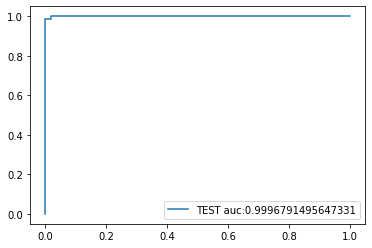

In [52]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics

clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="TEST auc:"+str(auc))
plt.legend(loc=4)
plt.show()

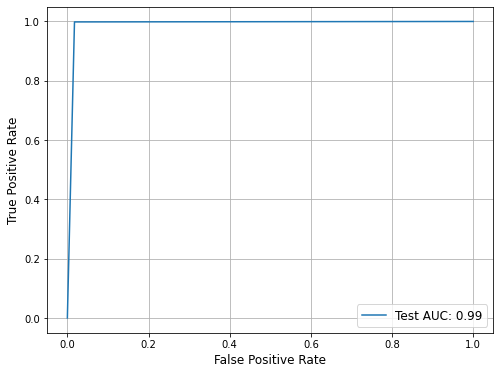

In [53]:
test_fpr, test_tpr, _ = metrics.roc_curve(y_test.values, y_pred)
test_auc = np.round(metrics.auc(test_fpr, test_tpr), 3)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
#ax.plot(test_fpr, test_tpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [69]:
feature_importances = pd.DataFrame(cls_forest.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)


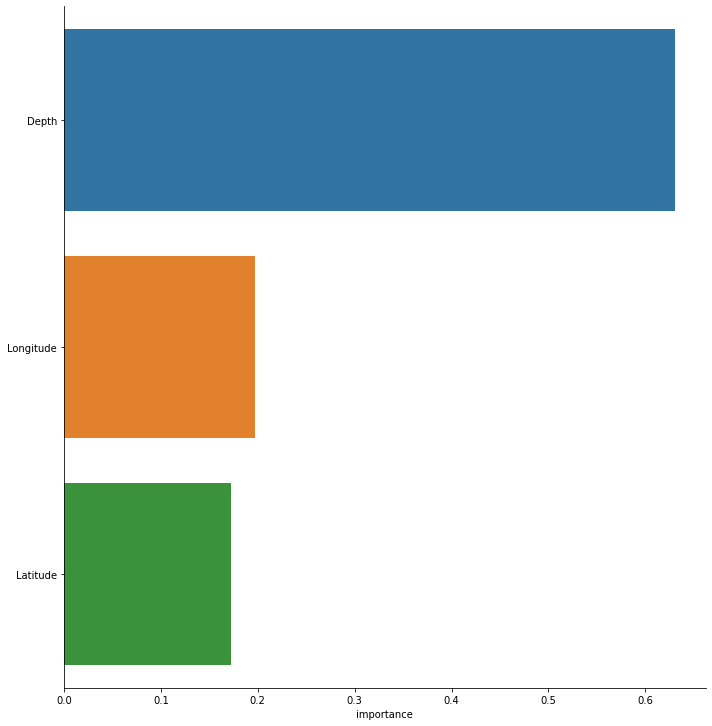

In [70]:

sns.catplot(x=feature_importances['importance'], y=feature_importances['importance'].index,kind="bar", data=feature_importances, height=10)

Ceci nous montre que la feature la plus importante est la profondeur

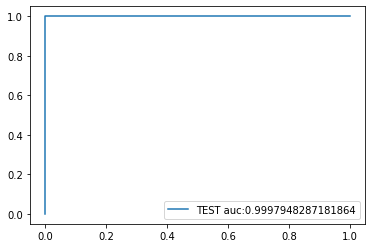

In [71]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics

clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="TEST auc:"+str(auc))
plt.legend(loc=4)
plt.show()

In [66]:
test2 = hearthquake
test2
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for col in test2.columns:
    test2[col] = label.fit_transform(test2[col])
# Print Updated Data
test2.head(100)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
0,0,11785,14682,16287,0,1670,28,2579,4,20,11,0
1,1,9866,11587,13420,0,1180,19,2580,4,20,11,0
2,2,15448,4821,2000,0,450,31,2581,4,20,11,0
3,3,16088,344,7646,0,359,19,2582,4,20,11,0
4,4,11612,13396,13050,0,359,19,2583,4,20,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,46,2313,6441,2235,0,606,39,2520,4,20,11,0
96,46,19561,2510,5903,0,851,31,2521,4,20,11,0
97,47,20401,6365,2261,0,529,31,2522,4,20,11,0
98,48,19370,12841,13122,0,925,14,2523,4,20,11,0


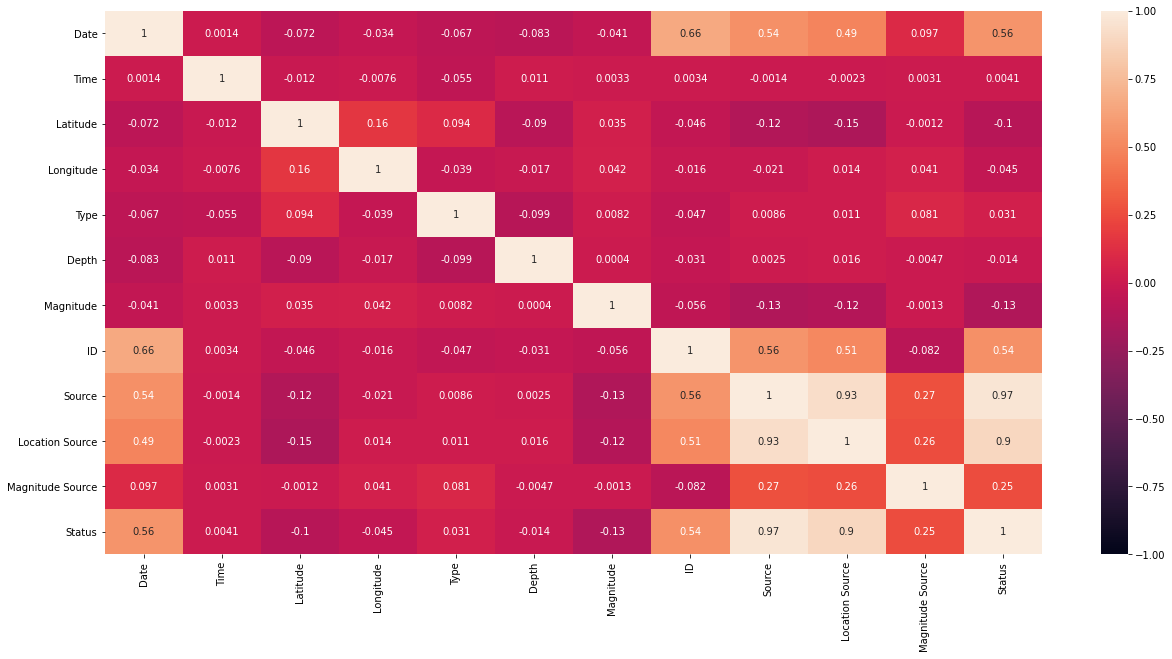

In [68]:
corr_test = test2.corr()
plt.figure(figsize=(21, 10))
sns.heatmap(corr_test, annot=True, vmin=-1.0, vmax=1.0)
plt.show()